# コートデータセットのCOCO形式アノテーション解析ノートブック

このノートブックは、コートデータセットにおける、COCO形式のアノテーションファイル（JSON）を読み込み、その内容を解析・可視化する手順を示します。

**目的:**
- COCOデータセットの構造を理解する
- データセットの基本的な統計情報を表示する
- アノテーション（特にコートのキーポイント）を画像上に描画して確認する

In [1]:
import json
import os
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

print("ライブラリのインポートが完了しました。")

ライブラリのインポートが完了しました。


In [2]:
# --- 設定項目 ---
# アノテーションファイルへのパス
annotation_file = '../data/processed/court/annotation.json' 
# 画像が格納されているディレクトリへのパス
image_dir = '../data/processed/court/images'
# ----------------

# JSONファイルを辞書型として読み込む
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

print("アノテーションファイルの読み込みが完了しました。")

アノテーションファイルの読み込みが完了しました。


In [3]:
# COCOデータの主要なキーを確認
print("COCOデータのキー:")
print(coco_data.keys())

# 各キーの要素数を表示
print("\n--- データセットの概要 ---")
print(f"情報 (info): {len(coco_data.get('info', []))}")
print(f"ライセンス (licenses): {len(coco_data.get('licenses', []))}")
print(f"画像 (images): {len(coco_data.get('images', []))}")
print(f"アノテーション (annotations): {len(coco_data.get('annotations', []))}")
print(f"カテゴリ (categories): {len(coco_data.get('categories', []))}")

COCOデータのキー:
dict_keys(['images', 'annotations', 'categories'])

--- データセットの概要 ---
情報 (info): 0
ライセンス (licenses): 0
画像 (images): 8841
アノテーション (annotations): 8841
カテゴリ (categories): 1


### COCOフォーマットの主要なキー
- **info**: データセットに関する基本情報（作成年、バージョンなど）。
- **licenses**: 画像に適用されるライセンス情報。
- **images**: データセット内の全画像の情報リスト。各要素は画像の`id`, `file_name`, `width`, `height`などを含む。
- **annotations**: 全てのアノテーション情報のリスト。各要素は`id`, `image_id`, `category_id`, `keypoints`（キーポイント）, `num_keypoints`（キーポイント数）などを含む。
- **categories**: カテゴリ（クラス）の情報リスト。各要素は`id`, `name`などを含む。

In [4]:
# 画像IDをキーとして画像情報へアクセスできる辞書を作成
images_map = {img['id']: img for img in coco_data['images']}

# カテゴリIDをキーとしてカテゴリ情報へアクセスできる辞書を作成
categories_map = {cat['id']: cat['name'] for cat in coco_data['categories']}

# 画像IDをキーとして、その画像に紐づくアノテーションのリストへアクセスできる辞書を作成
# defaultdictを使うと、キーが存在しない場合に自動で空のリストを作成してくれるので便利
annotations_map = defaultdict(list)
for ann in coco_data['annotations']:
    annotations_map[ann['image_id']].append(ann)

print("データ構造の変換が完了しました。")
print(f"例: 画像ID 1 のファイル名 -> {images_map[1]['file_name'] if 1 in images_map else 'N/A'}")
print(f"例: カテゴリID 1 の名前 -> {categories_map[1] if 1 in categories_map else 'N/A'}")

データ構造の変換が完了しました。
例: 画像ID 1 のファイル名 -> PuXlxKdUIes_2450.png
例: カテゴリID 1 の名前 -> court


### コートキーポイントを描写する

{'id': 1, 'name': 'court', 'keypoints': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'], 'skeleton': [[1, 2], [1, 3], [2, 4], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]]}
キーポイントを持つ画像からランダムに選択された画像 ID: 5693


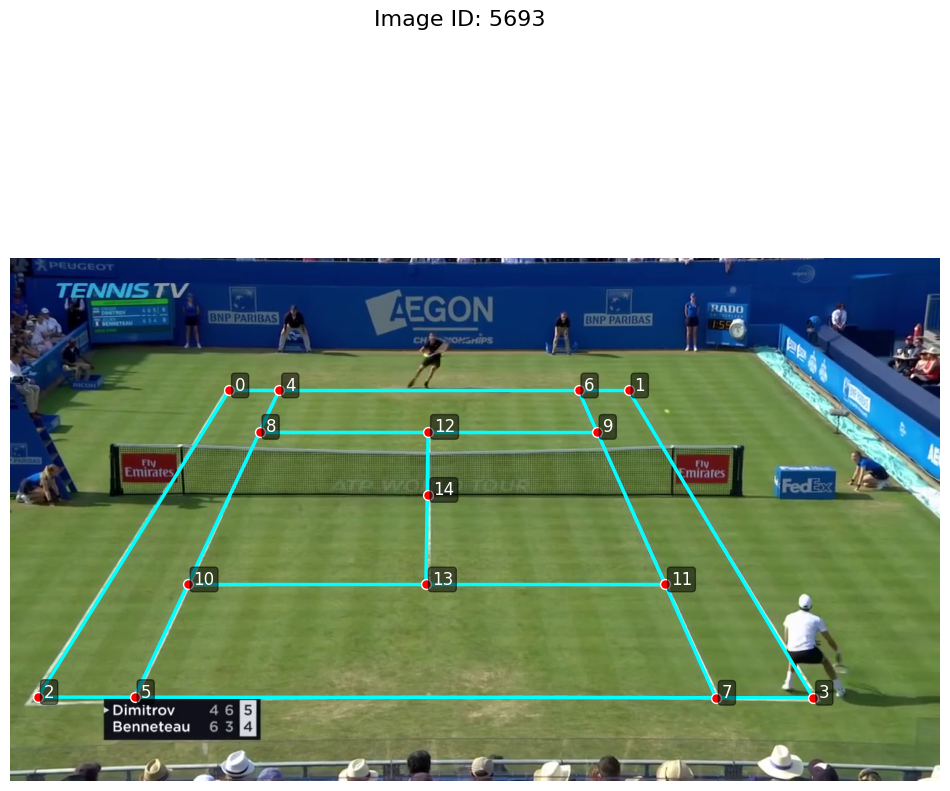

In [5]:
# (このセルの前に、ライブラリのインポートや各種mapの作成が完了している必要があります)

# キーポイントの色を定義
KEYPOINT_COLORS = {1: 'orange', 2: 'red'} # v=1: occluded, v=2: visible

# カテゴリ情報からスケルトン定義を取得
# データセットにカテゴリが1つしかないと仮定
category_info = coco_data['categories'][0] 
print(category_info)
skeleton = category_info.get('skeleton', [])
if not skeleton:
    print("警告: アノテーションファイルに'skeleton'の定義が見つかりませんでした。")

def visualize_annotation(image_id):
    """
    指定されたimage_idの画像とアノテーション（キーポイント、ID、スケルトン）を可視化する関数
    """
    # 1. 画像情報を取得
    image_info = images_map.get(image_id)
    if not image_info:
        print(f"エラー: 画像ID {image_id} が見つかりません。")
        return
    image_path = os.path.join(image_dir, image_info['file_name'])
    
    # 2. 画像を読み込む
    try:
        img = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"エラー: 画像ファイル {image_path} が見つかりません。")
        return
    
    # 3. アノテーション情報を取得
    annotations = annotations_map.get(image_id, [])
    
    # 4. 描画の準備
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)
    ax.axis('off')
    
    # 5. 各アノテーションを描画
    for ann in annotations:
        if 'keypoints' not in ann or not ann['keypoints']:
            continue

        keypoints = np.array(ann['keypoints']).reshape(-1, 3)

        # --- スケルトンの描画 ---
        for connection in skeleton:
            # skeletonのIDは1-basedなので、0-basedのインデックスに変換
            kp_idx1 = connection[0] - 1
            kp_idx2 = connection[1] - 1
            
            x1, y1, v1 = keypoints[kp_idx1]
            x2, y2, v2 = keypoints[kp_idx2]
            
            # 両方のキーポイントがアノテーションされている場合のみ線を描画
            if v1 > 0 and v2 > 0:
                ax.plot([x1, x2], [y1, y2], linewidth=2.5, color='cyan', zorder=2)

        # --- キーポイントとIDの描画 ---
        for i, (x, y, v) in enumerate(keypoints):
            if v > 0:
                ax.scatter(x, y, s=50, color=KEYPOINT_COLORS[v], edgecolors='white', linewidth=1, zorder=3)
                ax.text(x + 8, y, str(i), color='white', fontsize=12,
                        bbox=dict(facecolor='black', alpha=0.5, pad=1, boxstyle='round,pad=0.2'), zorder=4)
                
    fig.suptitle(f'Image ID: {image_id}', y=0.92, fontsize=16)
    plt.show()

# --- 実行部分 ---

# キーポイントアノテーションを持つ画像のIDリストを作成
keypoint_image_ids = {
    ann['image_id'] for ann in coco_data.get('annotations', []) 
    if 'keypoints' in ann and sum(ann['keypoints'][2::3]) > 0
}

if keypoint_image_ids:
    # ランダムに画像を選んで可視化
    random_image_id = random.choice(list(keypoint_image_ids))
    print(f"キーポイントを持つ画像からランダムに選択された画像 ID: {random_image_id}")
    visualize_annotation(random_image_id)
else:
    print("このデータセットにはキーポイントアノテーションが含まれていないようです。")

# 特定のIDで試したい場合
# test_image_id = 12345 # 試したいIDに書き換えてください
# if test_image_id in keypoint_image_ids:
#     visualize_annotation(test_image_id)
# else:
#     print(f"画像ID {test_image_id} には有効なキーポイントアノテーションがありません。")

### キーポイントの欠損状況の分析
1つのコートに対して、いくつのキーポイントが「見える（visible > 0）」状態でアノテーションされているかを集計します。これにより、アノテーションが不完全なデータがどれくらいあるかを把握できます。  

**目的:**
- アノテーションの品質を評価する。
- 「キーポイントが3つしか付いていない」といった低品質なデータを除外する際の基準を作る。

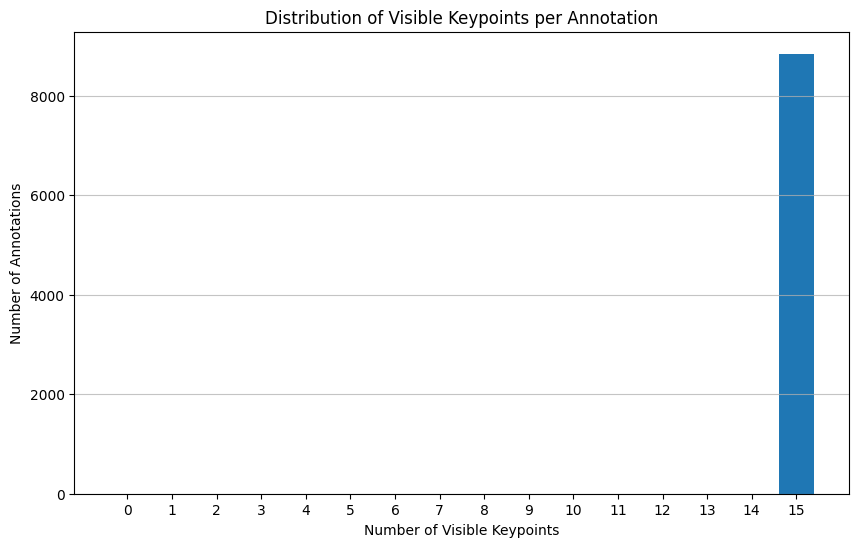

In [6]:
# 各アノテーションに含まれる有効なキーポイント数をカウント
num_visible_keypoints = []
for ann in coco_data['annotations']:
    # keypointsが存在し、リストが空でないことを確認
    if 'keypoints' in ann and ann['keypoints']:
        # v > 0 のキーポイントの数を数える (vは3要素ごとの3番目)
        count = sum(1 for v in ann['keypoints'][2::3] if v > 0)
        num_visible_keypoints.append(count)

# ヒストグラムで可視化
plt.figure(figsize=(10, 6))
plt.hist(num_visible_keypoints, bins=range(max(num_visible_keypoints) + 2), align='left', rwidth=0.8)
plt.title('Distribution of Visible Keypoints per Annotation')
plt.xlabel('Number of Visible Keypoints')
plt.ylabel('Number of Annotations')
plt.xticks(range(max(num_visible_keypoints) + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

### 各キーポイントの可視性（Visibility）の分析
カテゴリで定義された各キーポイント（例：「ネットポスト左」「ベースライン右端」など）が、データセット全体でどれくらいの割合で「見える(v=2)」または「隠れている(v=1)」と記録されているかを集計します。

**目的：**
- 特定のキーポイントが常に隠れがち（例：遠近法で奥になるポイント）など、データセットの撮影角度の偏りを理解する。
- モデルが学習しにくいキーポイントを特定する。

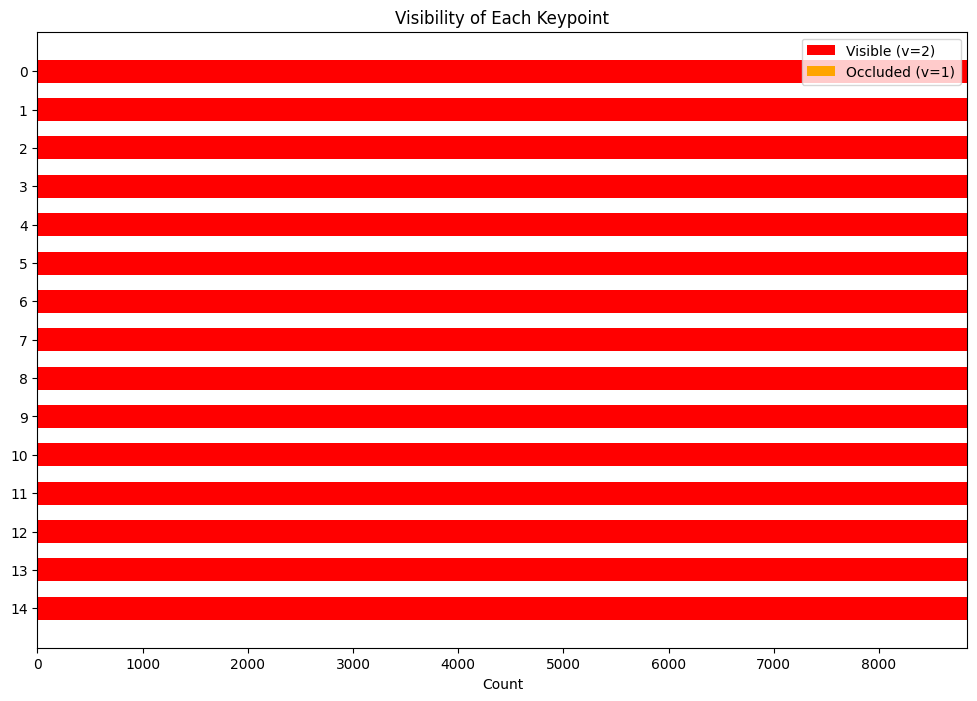

In [7]:
# カテゴリ情報を取得 (keypointの名前リストを含む)
category_info = coco_data['categories'][0] # カテゴリが1つと仮定
keypoint_names = category_info['keypoints']

# 各キーポイントの可視性をカウント
visibility_counts = {name: {'visible': 0, 'occluded': 0} for name in keypoint_names}

for ann in coco_data['annotations']:
    if 'keypoints' in ann and ann['keypoints']:
        keypoints = np.array(ann['keypoints']).reshape(-1, 3)
        for i, (x, y, v) in enumerate(keypoints):
            if v == 2: # visible
                visibility_counts[keypoint_names[i]]['visible'] += 1
            elif v == 1: # occluded
                visibility_counts[keypoint_names[i]]['occluded'] += 1

# グラフ化
labels = keypoint_names
visible_counts = [visibility_counts[name]['visible'] for name in labels]
occluded_counts = [visibility_counts[name]['occluded'] for name in labels]

width = 0.6
fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(labels, visible_counts, width, label='Visible (v=2)', color='red')
ax.barh(labels, occluded_counts, width, left=visible_counts, label='Occluded (v=1)', color='orange')

ax.set_xlabel('Count')
ax.set_title('Visibility of Each Keypoint')
ax.legend()
ax.invert_yaxis()

plt.show()